# Подготовка данных
 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
ad_costs = pd.read_csv('/datasets/costs_info_short.csv')

In [2]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
visits.info()
#display(visits['Region'].value_counts())
#display(visits['Device'].value_counts())
#display(visits['Channel'].value_counts())
#display(visits.sample(40))
#

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

display((visits['session_end'] - visits['session_start']).max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null object
session_end      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Timedelta('0 days 06:10:57')

Данные в порядке, отформатировал названия столбцов. Проверил что длинна сессии не превышает одни сутки и привел таймстампы к датам.

In [3]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders.info()
orders['event_dt'] = pd.to_datetime(orders['event_dt']).dt.date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null object
revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Данные в порядке, отформатировал названия столбцов.

In [4]:
ad_costs.columns = ad_costs.columns.str.lower().str.replace(' ', '_')
ad_costs.info()
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date
#display(ad_costs['channel'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Данные в порядке, отфарматировал названия столбцов.

# Функции для расчета метрик

Буду пользоваться своими аутентичными функциями для расчета метрик. Функции для расчета метрик из уроков это графомания.

## Профили

In [5]:
def get_profiles(visits, orders, ad_costs):
    
    #Профили
    profiles = (
        visits.sort_values(['user_id', 'session_start']).
        groupby('user_id').
        agg({'region':'first', 'device': 'first', 'channel': 'first', 'session_start': 'first'}).
        reset_index().
        rename(columns={'session_start': 'first_ts'})
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    #Стоимость привлечения
    ad_costs = ad_costs.merge(
        profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).reset_index(),
        how='left',
        on=['dt', 'channel']
    )
    ad_costs['cac'] = ad_costs['costs']/ad_costs['user_id']
    
    
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'cac']],
        how='left',
        on=['dt', 'channel']
    )
    profiles['cac'] = profiles['cac'].fillna(0)
    
    return profiles

In [6]:
profiles = get_profiles(visits, orders, ad_costs)

In [7]:
#display(profiles)

## Удержание

In [8]:
def get_retention(profiles, visits, date, horizon, groups=[]):
    
    profiles = profiles[profiles['dt'] <= (date - pd.Timedelta(days=horizon - 1))].copy()
    visits = visits[visits['session_start'].dt.date <= date].copy()
    
    if len(groups) == 0:
        profiles['cohort'] = 'all cohorts'
        groups.append('cohort')
        
    groups.append('payer')

    ret_raw = (
        profiles.
        merge(
            visits[['user_id', 'session_start']],
            how='left',
            on='user_id'
        )
    )
        
    ret_raw['lt'] = (ret_raw['session_start'] - ret_raw['first_ts']).dt.days
    ret_raw = ret_raw[ret_raw['lt'] < horizon]
    
    cohorts_size = profiles.groupby(groups).agg({'user_id':'nunique'})['user_id']
    ret_res = (
        ret_raw.
        pivot_table(index=groups, columns='lt', values='user_id', aggfunc='nunique').
        div(cohorts_size, axis=0)
    )
    ret_res['cohort_size'] = cohorts_size

    return ret_raw, ret_res.fillna(0)

In [9]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ret_raw, ret_res = get_retention(profiles, visits, max_date, 7, ['device'])

In [10]:
display(ret_res)

lt               0         1         2         3         4         5  \
device  payer                                                          
Android False  1.0  0.176820  0.086579  0.052458  0.033352  0.024337   
        True   1.0  0.405365  0.325385  0.269250  0.227024  0.222553   
Mac     False  1.0  0.175985  0.084604  0.049494  0.033200  0.025017   
        True   1.0  0.391235  0.304646  0.227033  0.211721  0.192186   
PC      False  1.0  0.175368  0.087036  0.051016  0.034653  0.024492   
        True   1.0  0.439947  0.357001  0.285335  0.276045  0.228932   
iPhone  False  1.0  0.178460  0.086648  0.052231  0.035926  0.024527   
        True   1.0  0.394468  0.303067  0.258870  0.212568  0.199339   

lt                    6  cohort_size  
device  payer                         
Android False  0.017599        32502  
        True   0.181818         2013  
Mac     False  0.019249        27741  
        True   0.173178         1894  
PC      False  0.017449        28540  
        True   0.231586         1507  
iPhone  False  0.019046        50353  
        True   0.179194         3326

## Конверсия

In [11]:
def get_conversion(profiles, orders, date, horizon, groups=[]):
    
    profiles = profiles[profiles['dt'] <= (date - pd.Timedelta(days=horizon - 1))].copy()
    orders = orders[orders['event_dt'] <= date].copy()
    
    if len(groups) == 0:
        profiles['cohort'] = 'all cohorts'
        groups.append('cohort')
        
    first_purchases = (
        orders.
        sort_values(['user_id', 'event_dt']).groupby('user_id').agg({'event_dt':'first'}).
        reset_index()
    )
    
    conv_raw = profiles.merge(
        first_purchases[['user_id', 'event_dt']],
        how='left',
        on='user_id'
    )
    

    conv_raw['lt'] = (conv_raw['event_dt'] - conv_raw['dt']).dt.days
    conv_raw = conv_raw[conv_raw['lt'] < horizon]
    
    cohorts_size = profiles.groupby(groups).agg({'user_id':'nunique'})['user_id']
    conv_res = (
        conv_raw.
        pivot_table(index=groups, columns='lt', values='user_id', aggfunc='nunique').
        fillna(0).
        cumsum(axis = 1).
        div(cohorts_size, axis=0)
        
    )
    conv_res['cohort_size'] = cohorts_size
    
    return conv_raw, conv_res.fillna(0)

In [12]:
max_date = pd.to_datetime(orders['event_dt'].max()).date()
conv_raw, conv_res = get_conversion(profiles, orders, max_date, 7, [])

In [13]:
#display(conv_res)

## LTV,  ROI

In [14]:
def get_ltv(profiles, orders, date, horizon, groups=[]):
    
    profiles = profiles[profiles['dt'] <= (date - pd.Timedelta(days=horizon - 1))].copy()
    orders = orders[orders['event_dt'] <= date].copy()
    
    if len(groups) == 0:
        profiles['cohort'] = 'all cohorts'
        groups.append('cohort')
        
    ltv_raw = profiles.merge(
        orders[['user_id', 'event_dt', 'revenue']],
        how='left',
        on='user_id'
    )
    ltv_raw['lt'] = (ltv_raw['event_dt'] - ltv_raw['dt']).dt.days
    ltv_raw = ltv_raw[ltv_raw['lt'] < horizon]
        
    #ltv
    cohorts_size = profiles.groupby(groups).agg({'user_id':'nunique'})['user_id']  
    ltv_res = (
        ltv_raw.
        pivot_table(index=groups, columns='lt', values='revenue', aggfunc='sum').
        fillna(0).
        cumsum(axis=1).
        div(cohorts_size, axis=0)
    )
    
    #roi
    cohorts_cac = profiles.groupby(groups).agg({'cac':'mean'})['cac']
    roi_res = ltv_res.div(cohorts_cac, axis=0)
    
    ltv_res['cohort_size'] = cohorts_size
    
    roi_res['cohort_size'] = cohorts_size
    roi_res['cac'] = cohorts_cac

    return ltv_raw, ltv_res.fillna(0), roi_res.fillna(0)

In [15]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ltv_raw, ltv_res, roi_res = get_ltv(profiles, orders, max_date, 7, [])

In [16]:
#display(roi_res)

# Функции графиков

In [17]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

## Графики удержания

In [18]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [19]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ret_raw, ret_res = get_retention(profiles, visits, max_date, 7, [])
ret_hist_raw, ret_hist = get_retention(profiles, visits, max_date, 7, ['dt'])

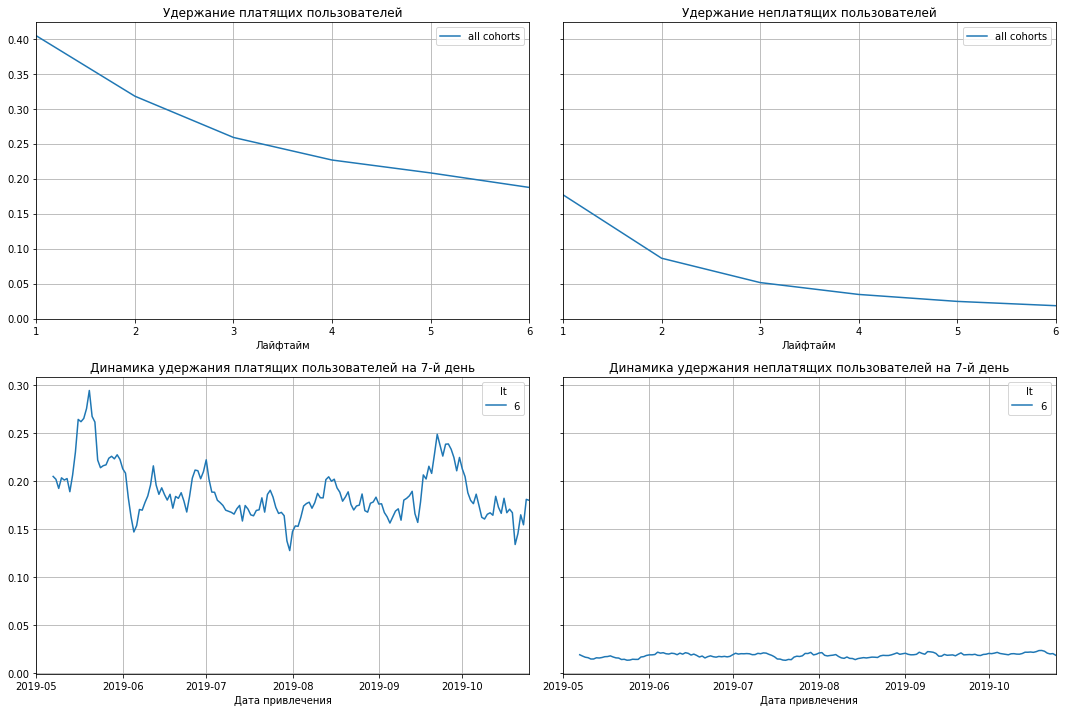

In [20]:
plot_retention(ret_res, ret_hist, 7)

## Графики конверсии

In [21]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [22]:
max_date = pd.to_datetime(orders['event_dt'].max()).date()
conv_raw, conv_res = get_conversion(profiles, orders, max_date, 7, [])
conv_hist_raw, conv_hist = get_conversion(profiles, orders, max_date, 7, ['dt'])

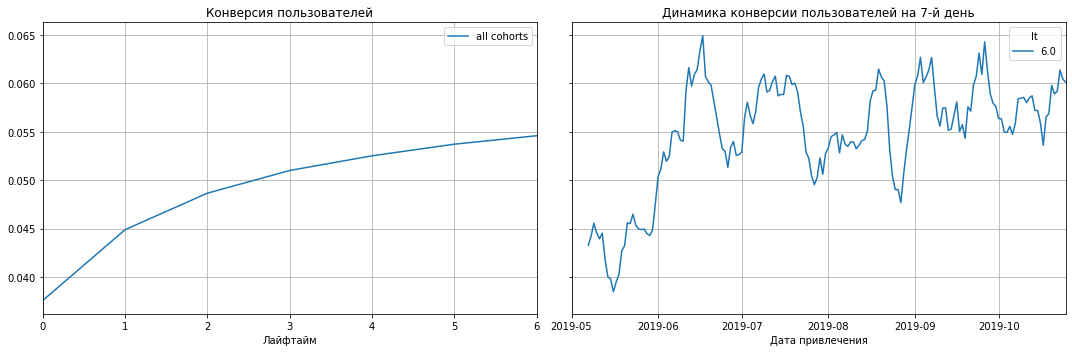

In [23]:
plot_conversion(conv_res, conv_hist, 7)

## Графики ltv, roi

In [24]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [25]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ltv_raw, ltv_res, roi_res = get_ltv(profiles, orders, max_date, 7, [])
ltv_hist_raw, ltv_hist_res, roi_hist_res = get_ltv(profiles, orders, max_date, 7, ['dt'])

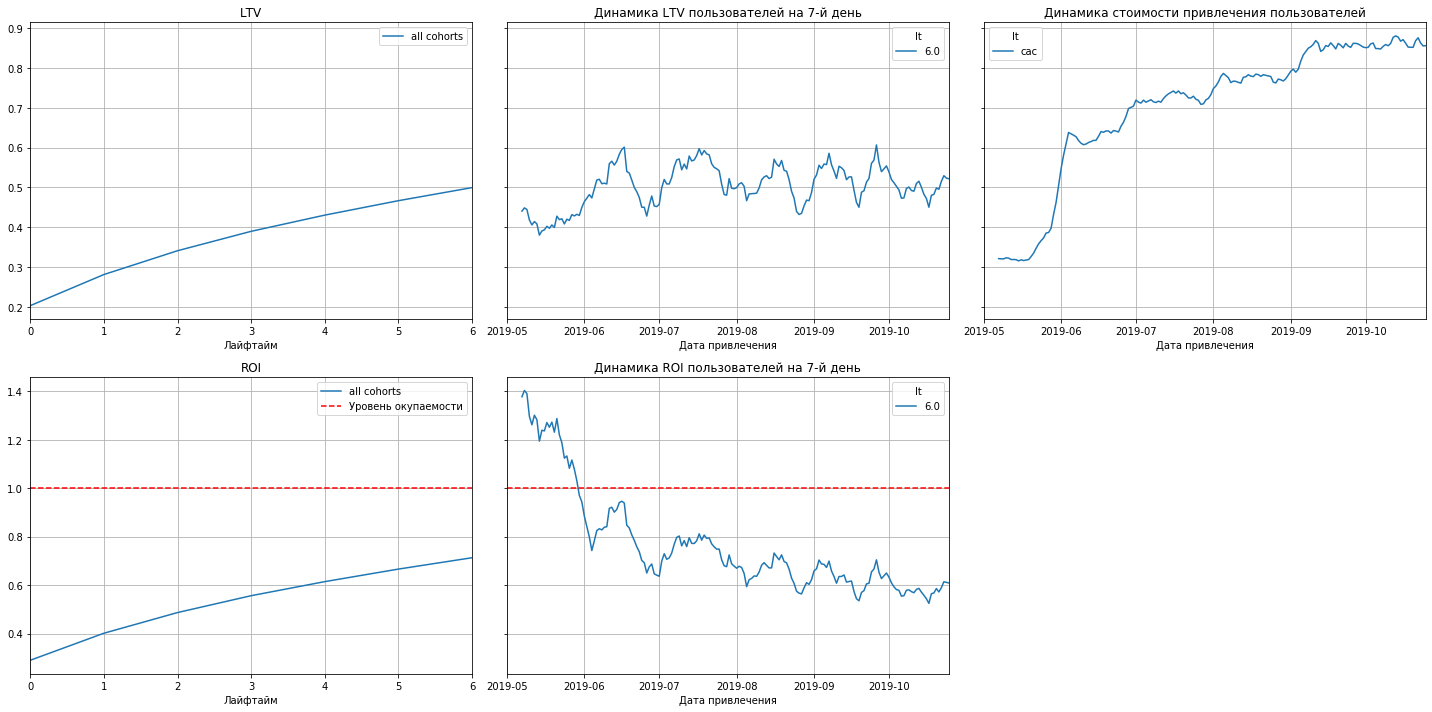

In [26]:
plot_ltv_roi(ltv_res, ltv_hist_res, roi_res, roi_hist_res, 7)

# EDA

Cтрою профили пользователей. Определяю минимальную и максимальную дату привлечения пользователей.

Основные вопросы:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [27]:
#Надо взять пользователей за последние несколько месяцев как сказанно в задании.
profiles = get_profiles(visits, orders, ad_costs)

In [28]:
profiles.shape

(150008, 9)

## Пользователи по регионам

In [29]:
profiles['region'].unique()

array(['United States', 'France', 'Germany', 'UK'], dtype=object)

### Все пользователи

In [30]:
profiles['region'].value_counts(normalize=True)

United States    0.666644
UK               0.117160
France           0.116327
Germany          0.099868
Name: region, dtype: float64

Основная масса пользователей из США - 66%. Остальные 3 региона делят 33%, примерно равно.

### Платящие пользователи

In [31]:
profiles[profiles['payer'] == True]['region'].value_counts(normalize=True)

United States    0.777165
UK               0.078820
France           0.074654
Germany          0.069362
Name: region, dtype: float64

Оснавная масса платящих пользователей так же из США 78%. Остальные регионы делят 22% примерно равно.

## Пользователи по устройствам

In [32]:
profiles['device'].unique()

array(['Mac', 'iPhone', 'PC', 'Android'], dtype=object)

### Все пользователи

In [33]:
profiles['device'].value_counts(normalize=True)

iPhone     0.363174
Android    0.233534
PC         0.203023
Mac        0.200269
Name: device, dtype: float64

Пользователей заходящих с iphone на 16% больше чем в среднем по другим устройствам.

### Платящие пользователи

In [34]:
profiles[profiles['payer'] == True]['device'].value_counts(normalize=True)

iPhone     0.380813
Android    0.230830
Mac        0.215291
PC         0.173066
Name: device, dtype: float64

Пользователи iphone представаляют 38% платящих пользователей. Так же еще 21% пользователей Mac. В сумме 59% платящих пользователей это сторонники продукции apple.

## Пользователи по каналам

In [35]:
profiles['channel'].unique()

array(['FaceBoom', 'organic', 'AdNonSense', 'YRabbit', 'MediaTornado',
       'RocketSuperAds', 'LeapBob', 'TipTop', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

### Все пользователи

In [36]:
profiles['channel'].value_counts(normalize=True)

organic               0.376240
FaceBoom              0.194283
TipTop                0.130400
OppleCreativeMedia    0.057364
WahooNetBanner        0.057017
LeapBob               0.057017
RocketSuperAds        0.029652
MediaTornado          0.029092
YRabbit               0.028745
AdNonSense            0.025865
lambdaMediaAds        0.014326
Name: channel, dtype: float64

Основная масса пользователей органическая - 38%

### Платящие пользователи

In [37]:
profiles[profiles['payer'] == True]['channel'].value_counts(normalize=True)

FaceBoom              0.400518
TipTop                0.211463
organic               0.130616
WahooNetBanner        0.051008
AdNonSense            0.049544
RocketSuperAds        0.039635
LeapBob               0.029501
OppleCreativeMedia    0.026236
lambdaMediaAds        0.025335
YRabbit               0.018579
MediaTornado          0.017566
Name: channel, dtype: float64

Основная масса платящих пользователей 40% пришли по каналу FaceBoom

## Каналы привлечения пользователей по устройствам

In [38]:
channels_size = profiles.groupby('channel').agg({'user_id':'count'})['user_id']

In [39]:
profiles.pivot_table(index='channel', columns='device', values='user_id', aggfunc='count').div(channels_size, axis=0)

device,Android,Mac,PC,iPhone
channel,,,,
AdNonSense,0.285825,0.105670,0.402835,0.205670
FaceBoom,0.201585,0.249279,0.103212,0.445924
LeapBob,0.301649,0.102888,0.397755,0.197708
MediaTornado,0.201421,0.253208,0.103804,0.441567
OppleCreativeMedia,0.293550,0.102499,0.406275,0.197676
RocketSuperAds,0.208633,0.255621,0.104766,0.430980
TipTop,0.198814,0.246409,0.102858,0.451920
WahooNetBanner,0.301298,0.100082,0.398574,0.200047
YRabbit,0.200603,0.254406,0.111781,0.433210


Каналы кроме органического, явно имеют некоторую брендовую направленность. Тк. большинство платящих пользователей сторонники apple есть смысл выделить бренд. Эта закономерность может быть связана с самими каналамии или с приложением как продуктом.

In [40]:
profiles['brand'] = profiles['device'].apply(lambda x: 'apple' if x in ('Mac', 'iPhone') else 'other')

In [41]:
channels_size = profiles.groupby('channel').agg({'user_id':'count'})['user_id']

In [42]:
(
    profiles.
    pivot_table(index='channel', columns='brand', values='user_id', aggfunc='count').
    div(channels_size, axis=0).
    merge(channels_size, on='channel')
)

,apple,other,user_id
channel,,,
AdNonSense,0.311340,0.688660,3880
FaceBoom,0.695203,0.304797,29144
LeapBob,0.300596,0.699404,8553
MediaTornado,0.694775,0.305225,4364
OppleCreativeMedia,0.300174,0.699826,8605
RocketSuperAds,0.686601,0.313399,4448
TipTop,0.698328,0.301672,19561
WahooNetBanner,0.300129,0.699871,8553
YRabbit,0.687616,0.312384,4312


Можно предположить что трафик каналов FaceBoom и TipTop на 70% состоит из сторонников apple. Тк. о приложении у нас никакой информации нет.

## Каналы привлечения пользователей по регионам

In [43]:
channels_size = profiles.groupby('channel').agg({'user_id':'count'})['user_id']

In [44]:
channels_by_regions = (profiles.
                       pivot_table(index='channel', columns='region', values='user_id', aggfunc='count').
                       div(channels_size, axis=0).
                       merge(channels_size, on='channel')
)

In [45]:
channels_by_regions

,France,Germany,UK,United States,user_id
channel,,,,,
AdNonSense,0.352062,0.314175,0.333763,NaN,3880
FaceBoom,NaN,NaN,NaN,1.000000,29144
LeapBob,0.349351,0.294517,0.356132,NaN,8553
MediaTornado,NaN,NaN,NaN,1.000000,4364
OppleCreativeMedia,0.347589,0.297734,0.354678,NaN,8605
RocketSuperAds,NaN,NaN,NaN,1.000000,4448
TipTop,NaN,NaN,NaN,1.000000,19561
WahooNetBanner,0.347363,0.301532,0.351105,NaN,8553
YRabbit,NaN,NaN,NaN,1.000000,4312


Аудитории ранее отмеченных каналов FaceBoom и TipTop на 100% состоят из жителей США. Так же наблюдается и с органикой, 67% органических пользователей находятся в США. Так же каналы привлечения, делятся на те что ориентированны только на США и те что ориентированны на все остальные регионы кроме США. Есть смысл разметить данные по аудитории канала.

In [46]:
usa_channels = channels_by_regions['United States'].dropna().index.values
profiles['channel_auditory'] = profiles['channel'].apply(lambda x: 'USA' if x in usa_channels else 'other')

In [47]:
profiles.pivot_table(index='brand', columns='channel_auditory', values='user_id', aggfunc='count')

channel_auditory,USA,other
brand,,
apple,74918,9603
other,43350,22137


Получается маркетинг настроен на пользователей USA и при этом сторонников apple.

# Маркетинг

Основные вопросы:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

## Расходы на маркетинг

In [48]:
ad_costs

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


In [49]:
ad_costs.costs.sum()

105497.30000000002

In [50]:
orders.revenue.sum() - ad_costs.costs.sum()

110465.57999999999

Всего расходы составили 105497 неизвестных единиц, далее денюшек. Прибыль 110465 денюшек, те. какой порог roi нас устроит и в какой лайфтайм не понятно и в задании не указано. Смотрим абстрактно.

In [51]:
ad_costs.groupby('channel').agg({'costs':'sum'})

,costs
channel,
AdNonSense,3911.25
FaceBoom,32445.60
LeapBob,1797.60
MediaTornado,954.48
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
TipTop,54751.30
WahooNetBanner,5151.00
YRabbit,944.22


Самыми дорогими оказались все теже FaceBoom и TipTop.

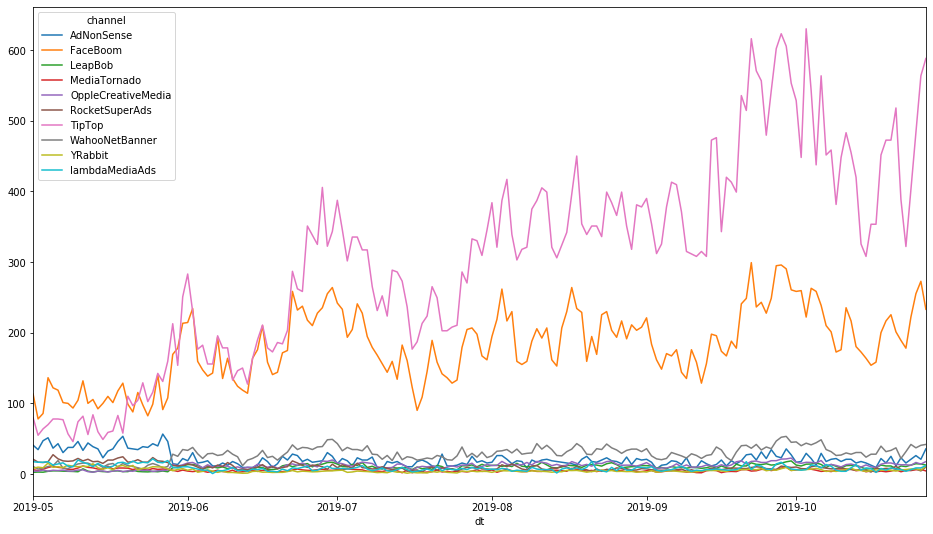

In [52]:
ad_in_time = ad_costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum').plot(figsize=(16,9))

Стоимость рекламы в FaceBoom и TipTop значительно возрастает после июня.

# Оценка окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Анализирую общую окупаемость рекламы;
- Анализирую окупаемость рекламы с разбивкой по устройствам;
- Анализирую окупаемость рекламы с разбивкой по странам;
- Анализирую окупаемость рекламы с разбивкой по рекламным каналам.

Основные вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

## Анализ окупаемости рекламы

### Общая окупаемость рекламы

In [53]:
profiles = profiles[profiles['channel'] != 'organic']

#### Ltv, Roi

In [82]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ltv_raw, ltv_res, roi_res = get_ltv(profiles, orders, max_date, 31, [])
ltv_hist_raw, ltv_hist_res, roi_hist_res = get_ltv(profiles, orders, max_date, 31, ['dt'])

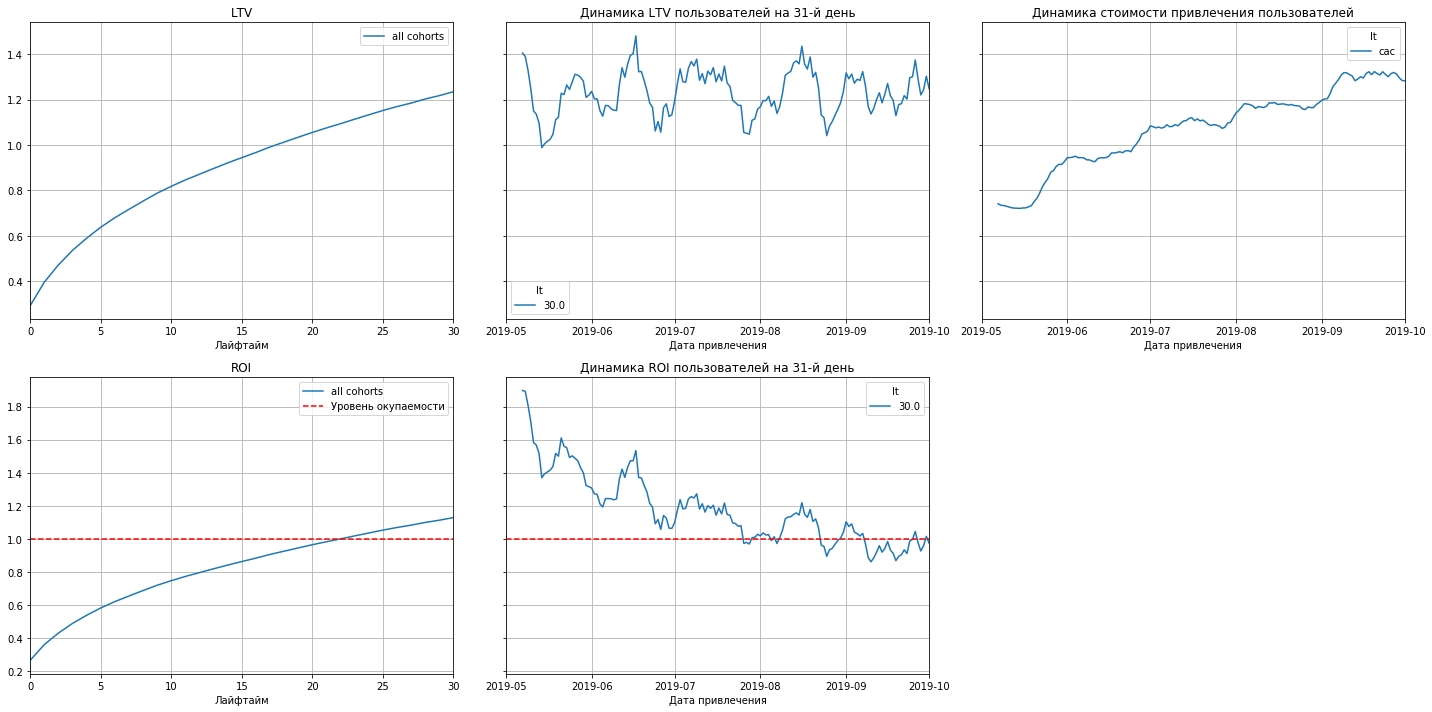

In [83]:
plot_ltv_roi(ltv_res, ltv_hist_res, roi_res, roi_hist_res, 31)

Реклама начинает окупатся с 23 дня. Расходы к июню возрастают на 100% и далее еще на 100%. Динамика ROI падает пропорционально росту стоимости рекламмы.

#### Конверсия

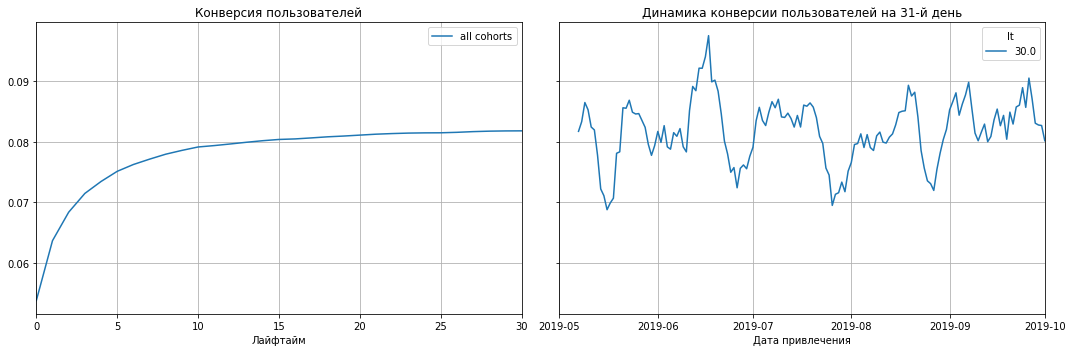

In [84]:
max_date = pd.to_datetime(orders['event_dt'].max()).date()
conv_raw, conv_res = get_conversion(profiles, orders, max_date, 31, [])
conv_hist_raw, conv_hist = get_conversion(profiles, orders, max_date, 31, ['dt'])
plot_conversion(conv_res, conv_hist, 31)

В динамике конверсия растет но незначительно. Есть смысл посмотреть стали ли мы привлекать больше пользователей.

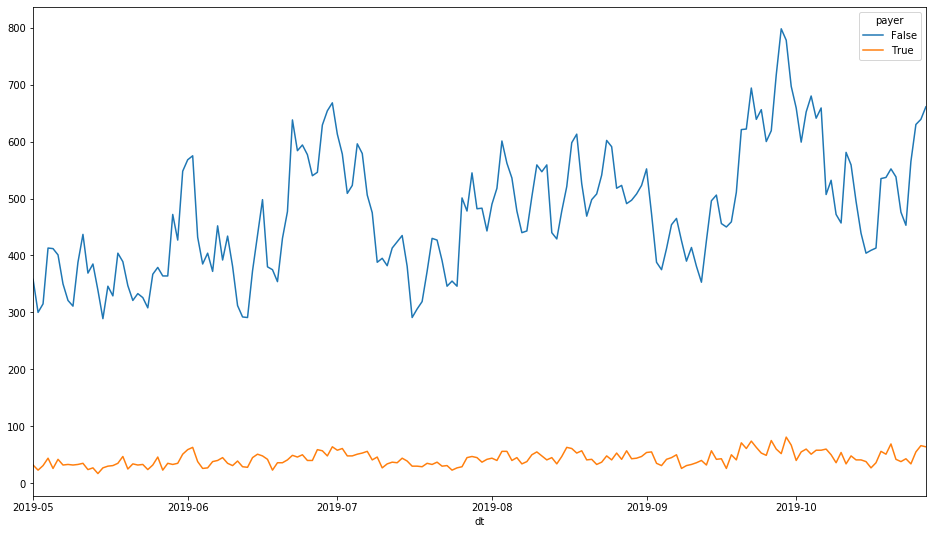

In [85]:
profiles.pivot_table(index='dt', columns='payer', values='user_id', aggfunc='count').plot(figsize=(16,9))

На общих графиках знаительного роста числа платящих пользователей нет. Не платящих пользователей в среднем становиться в 1.5 раза больше.

#### Удержание

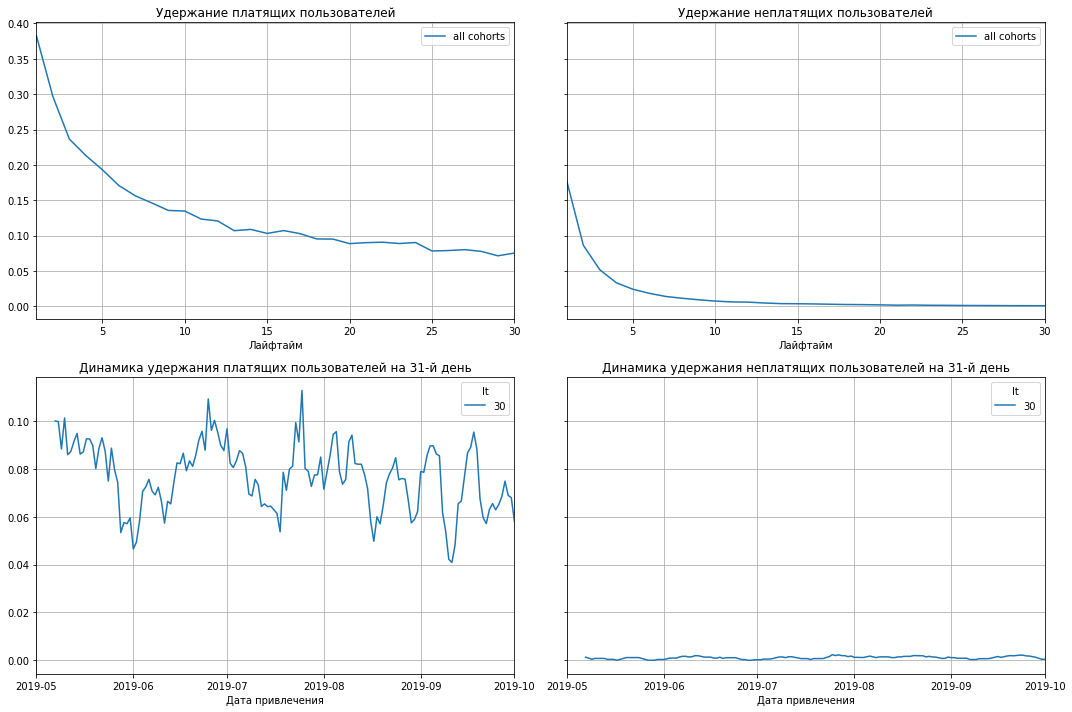

In [86]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ret_raw, ret_res = get_retention(profiles, visits, max_date, 31, [])
ret_hist_raw, ret_hist = get_retention(profiles, visits, max_date, 31, ['dt'])
plot_retention(ret_res, ret_hist, 31)

Значительное увеличения вложений в маркетинг после июня, на общем графике не отразилось.

### Окупаемость рекламы с разбивкой по устройствам

#### Ltv, Roi

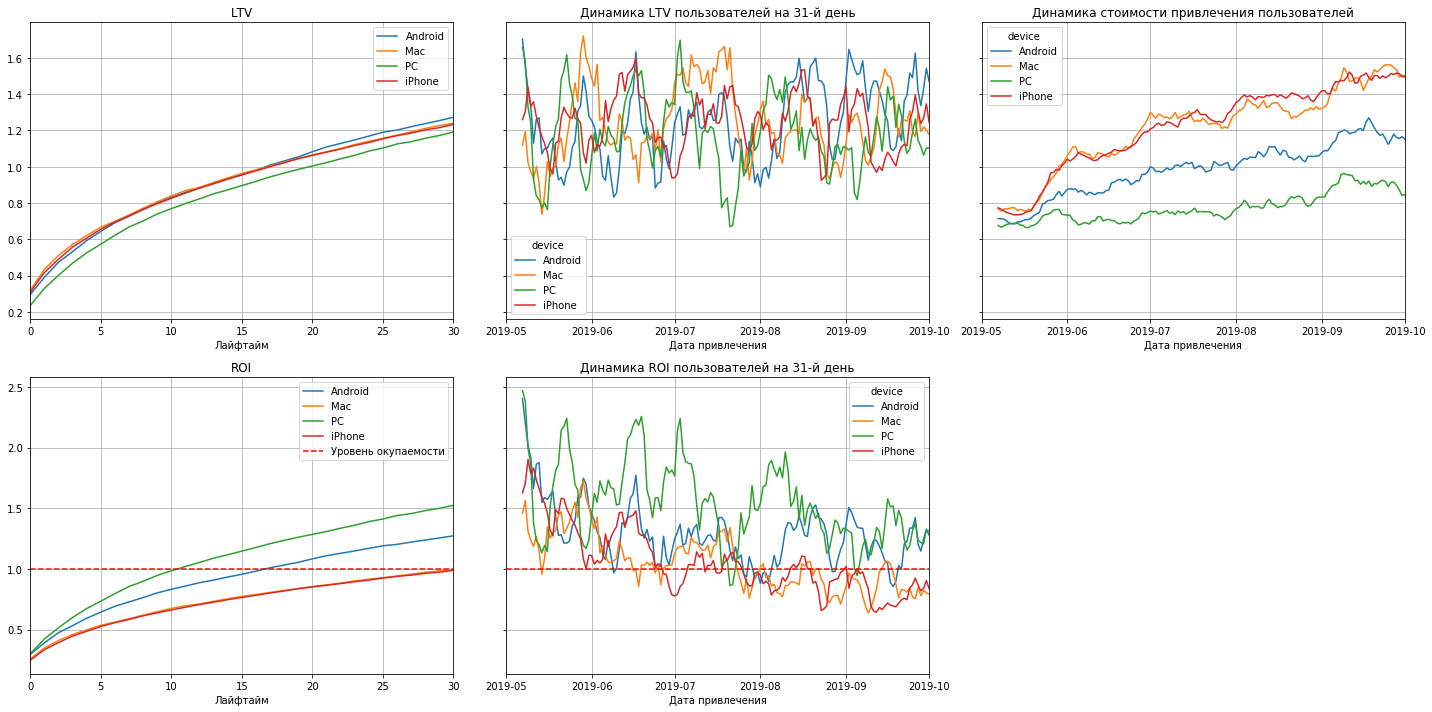

In [87]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ltv_raw, ltv_res, roi_res = get_ltv(profiles, orders, max_date, 31, ['device'])
ltv_hist_raw, ltv_hist_res, roi_hist_res = get_ltv(profiles, orders, max_date, 31, ['dt','device'])
plot_ltv_roi(ltv_res, ltv_hist_res, roi_res, roi_hist_res, 31)

Ожидаемо что рост стоимости привлечения пользователей Mac и iPhone выделяется тк. это аудитория FaceBoom и TipTop наших основных рекламных каналов.

Так же видно что пользователи PC и Android все еще окупаются.

#### Конверсия

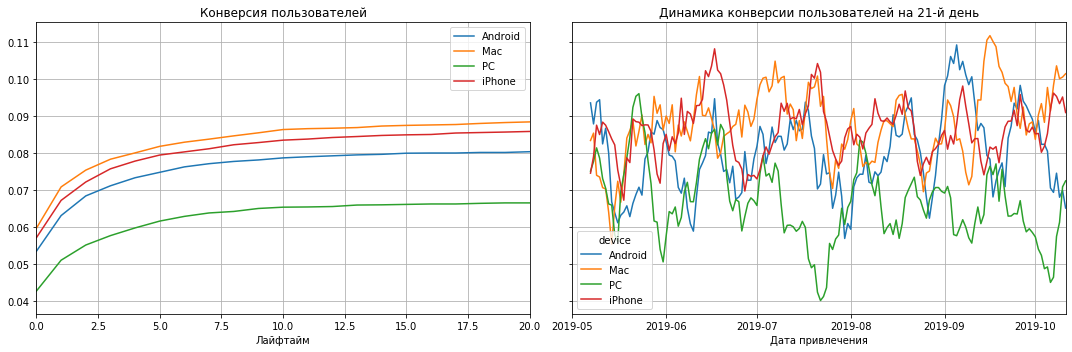

In [60]:
max_date = pd.to_datetime(orders['event_dt'].max()).date()
conv_raw, conv_res = get_conversion(profiles, orders, max_date, 21, ['device'])
conv_hist_raw, conv_hist = get_conversion(profiles, orders, max_date, 21, ['dt','device'])
plot_conversion(conv_res, conv_hist, 21)

Пользователи ПК конвертируются хуже всех. Динамика конверсии apple в среднем растет стабильно с июня. Android в июне возрастает но далее переживает разные возможно сезонные периоды, также с ПК.

#### Удержание

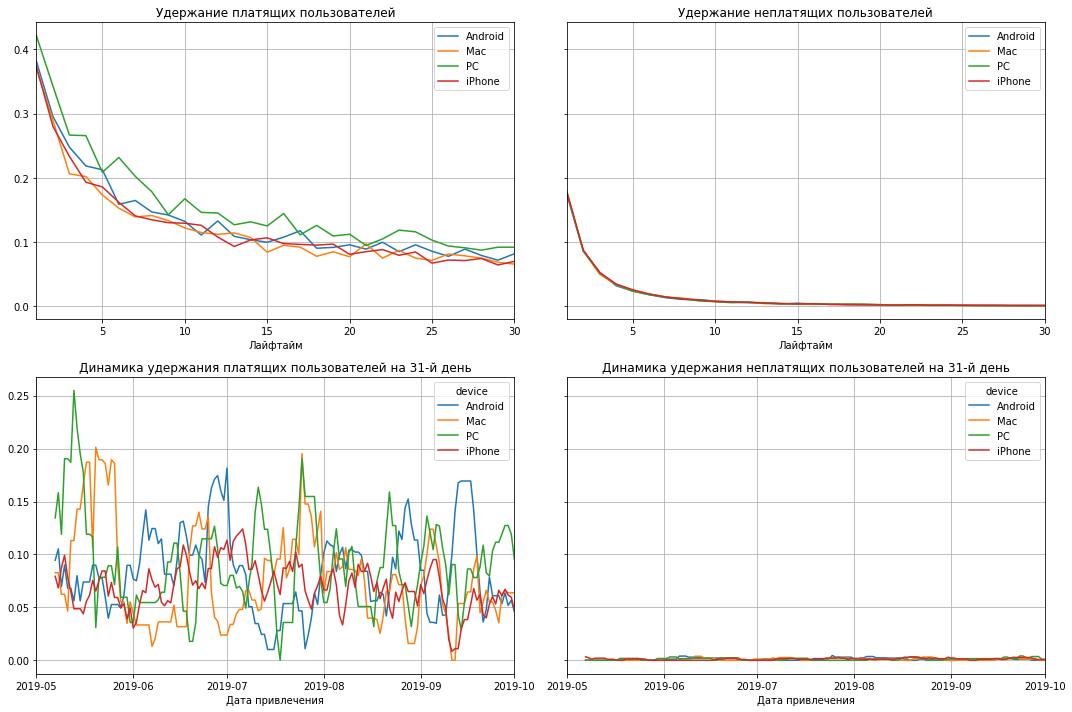

In [88]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ret_raw, ret_res = get_retention(profiles, visits, max_date, 31, ['device'])
ret_hist_raw, ret_hist = get_retention(profiles, visits, max_date, 31, ['device', 'dt'])
plot_retention(ret_res, ret_hist, 31)

Значительных изменений в динамике удержания нет, евсли не считать что максимум удержания приходится на первый месяц работы приложения. Похоже что видны скорее сезонные и другие переодические влияния, нежели отклик на увеличение вложений в маркетинг. Что логично т.к удержание вроде не вопрос постоянной рекламы.

### Окупаемость рекламы с разбивкой по странам

#### Ltv, Roi

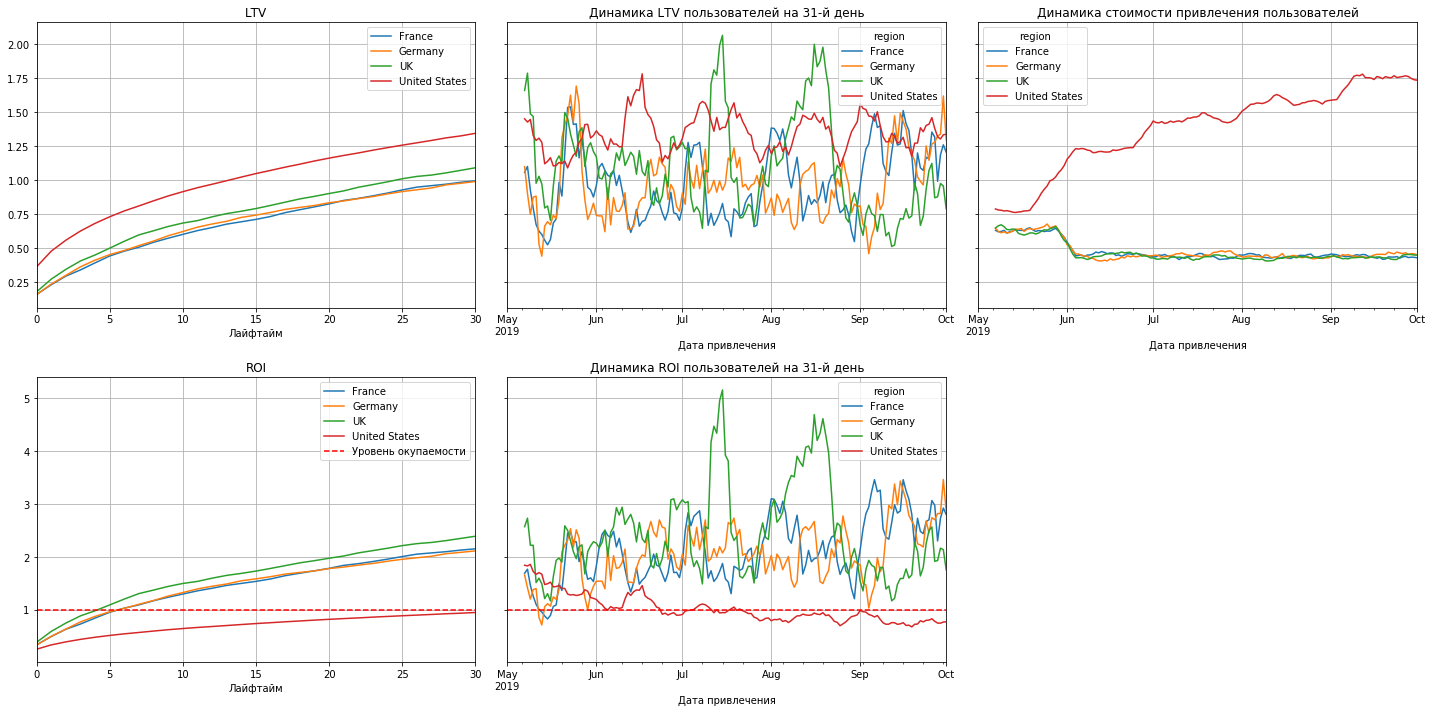

In [89]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ltv_raw, ltv_res, roi_res = get_ltv(profiles, orders, max_date, 31, ['region'])
ltv_hist_raw, ltv_hist_res, roi_hist_res = get_ltv(profiles, orders, max_date, 31, ['dt', 'region'])
plot_ltv_roi(ltv_res, ltv_hist_res, roi_res, roi_hist_res, 31)

Пользователи из США приносят больше денюшек чем пользователи из других регионов. Однако привлечение этих ползователей обошлось в разы дороже чем пользователей из других регионов. В итоге roi США лежит ниже линии окупаемости в плоть до 30 лайфтайма, по причине огромной цены привлечения. Все регионы кроме США выходят на окупаемость после 5 лайфтайма. Лучшее roi у пользователей UK. 

#### Конверсия

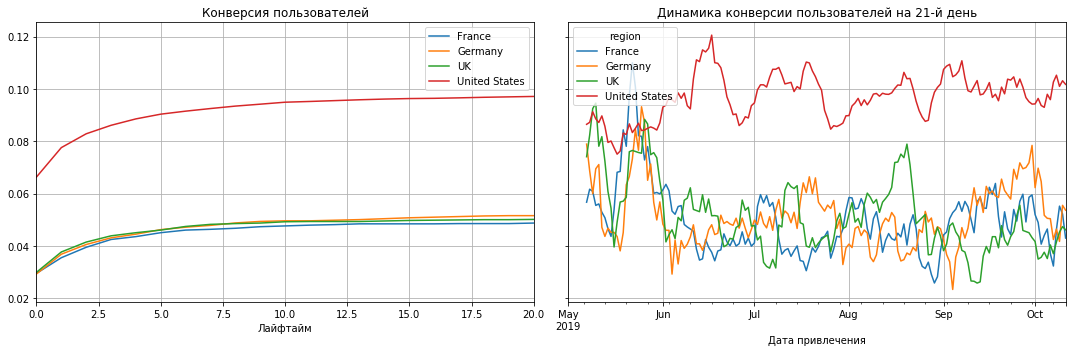

In [63]:
max_date = pd.to_datetime(orders['event_dt'].max()).date()
conv_raw, conv_res = get_conversion(profiles, orders, max_date, 21, ['region'])
conv_hist_raw, conv_hist = get_conversion(profiles, orders, max_date, 21, ['dt','region'])
plot_conversion(conv_res, conv_hist, 21)

Конверсия в США растет в июне откликаясб на первые вливания и дальнейшего роста не показывает хотя мы еще раз увеличили бюджет рекламы в США почти в двое, остальные регионы в среднем неизменны.

#### Удержание

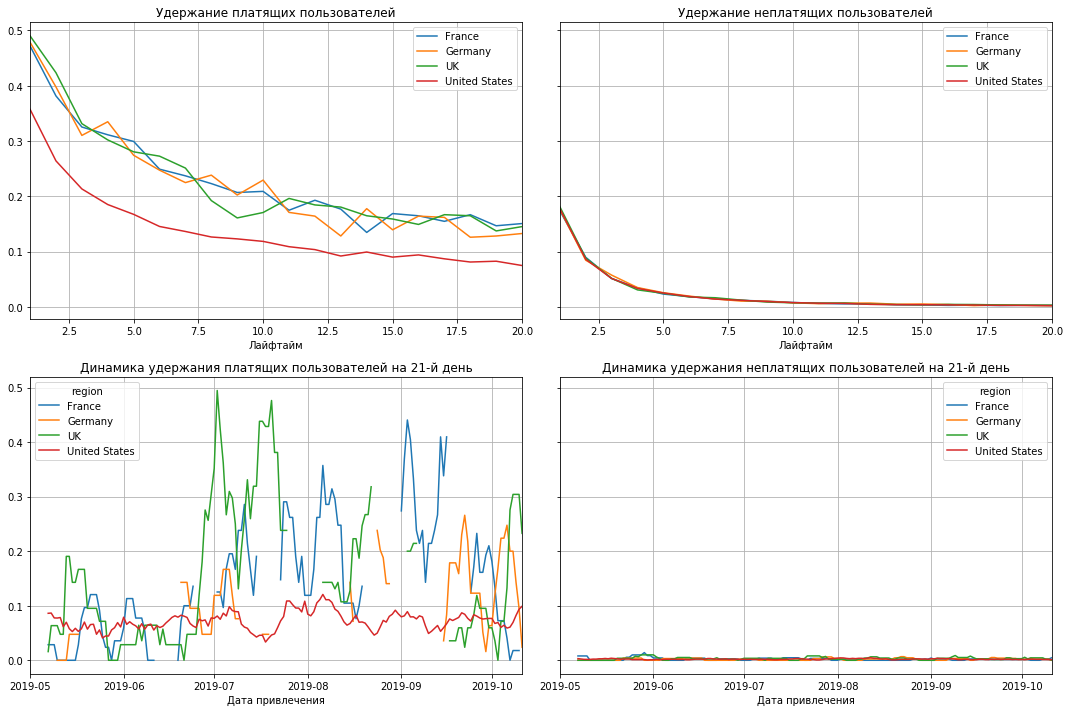

In [64]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ret_raw, ret_res = get_retention(profiles, visits, max_date, 21, ['region'])
ret_hist_raw, ret_hist = get_retention(profiles, visits, max_date, 21, ['region', 'dt'])
plot_retention(ret_res, ret_hist, 21)

Платящие пользователи из США удерживаются хуже всех прочих. По динамике так же хуже всех США. Видимо какая то особенность рынка приложений в США или особенность наших каналов.

### Окупаемость рекламы с разбивкой по рекламным каналам

#### Ltv, Roi

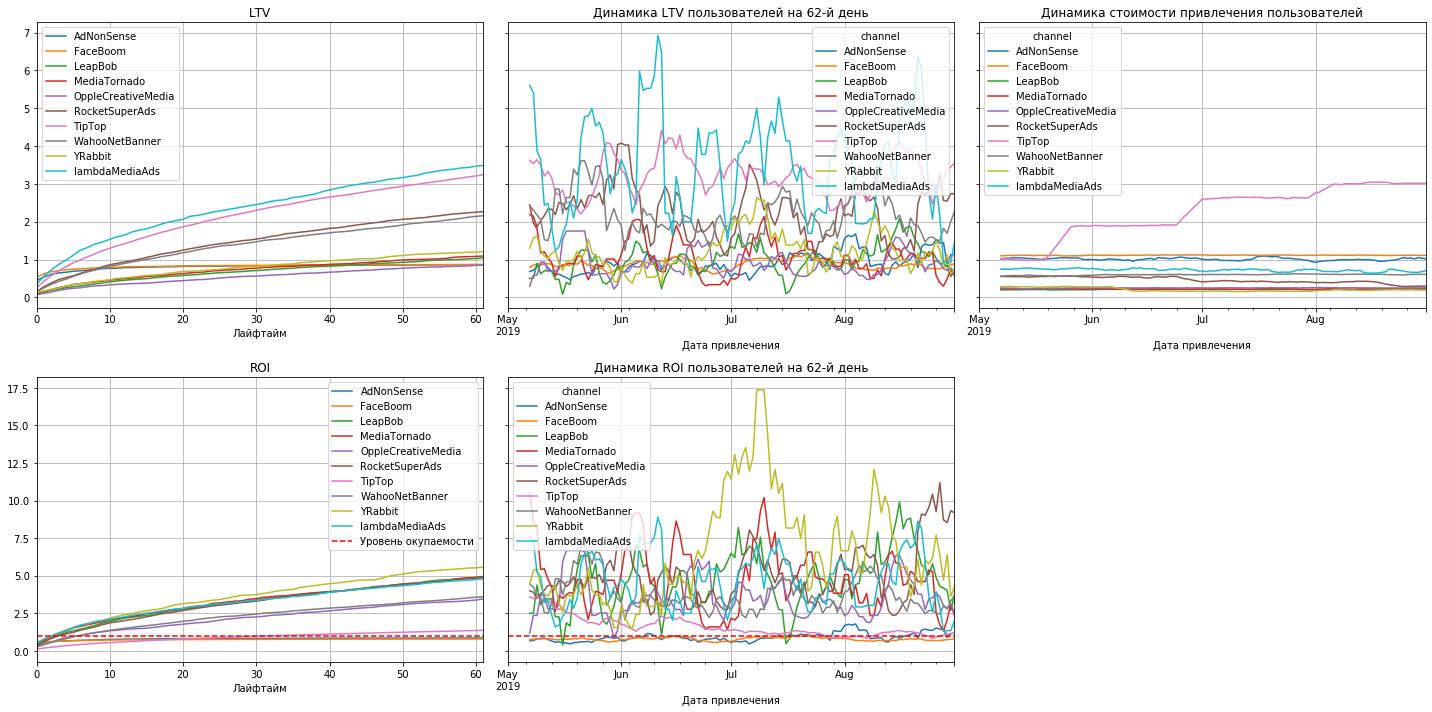

In [91]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ltv_raw, ltv_res, roi_res = get_ltv(profiles, orders, max_date, 62, ['channel'])
ltv_hist_raw, ltv_hist_res, roi_hist_res = get_ltv(profiles, orders, max_date, 62, ['dt', 'channel'])
plot_ltv_roi(ltv_res, ltv_hist_res, roi_res, roi_hist_res, 62)

TipTop в итоге окупается на 40 лайфтайме. Самые убыточные по итогу это AdNonSense и FaceBoom.,

Самые лучшие по динамике ROI пользователи из каналов YRabbit, LeapBob, MediaTornado.

#### Ltv, Roi только каналы в США

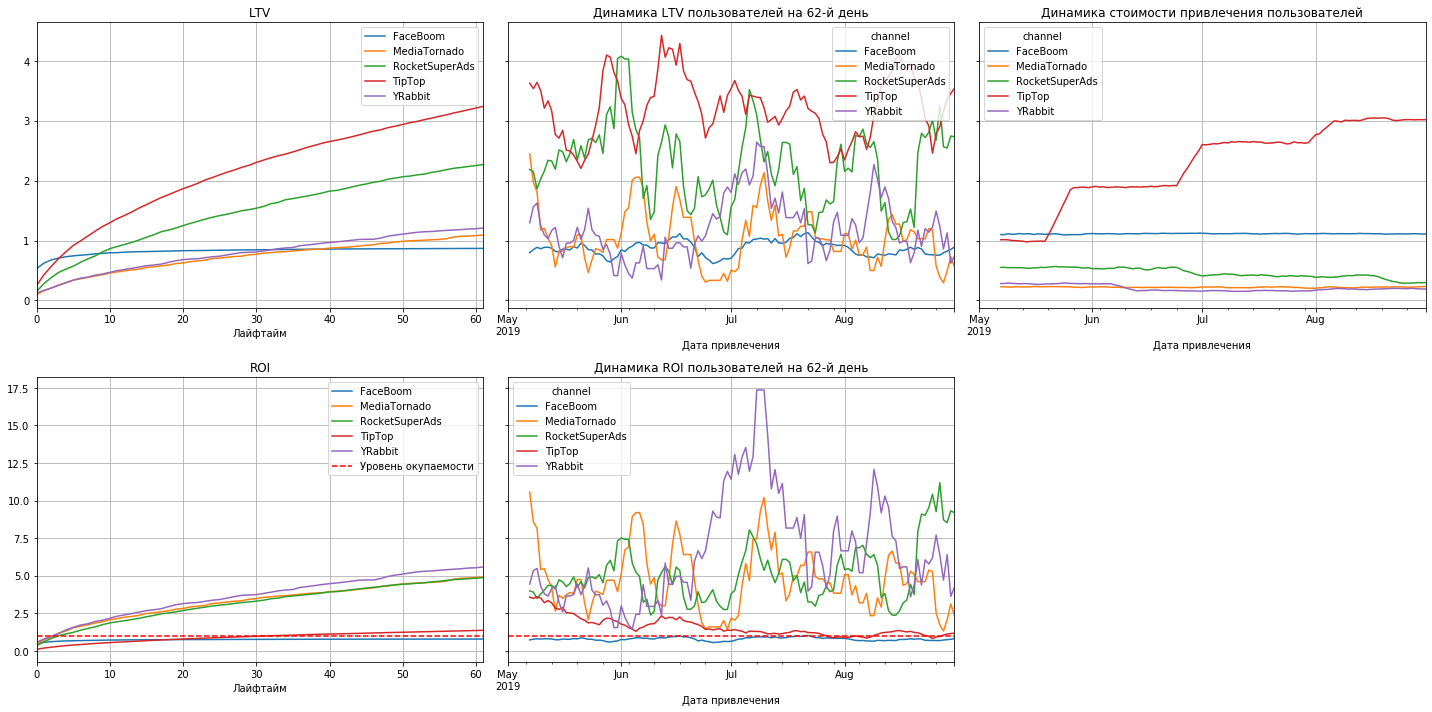

In [94]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ltv_raw, ltv_res, roi_res = get_ltv(profiles[profiles['channel_auditory'] == 'USA'], orders, max_date, 62, ['channel'])
ltv_hist_raw, ltv_hist_res, roi_hist_res = get_ltv(profiles[profiles['channel_auditory'] == 'USA'], orders, max_date, 62, ['dt', 'channel'])
plot_ltv_roi(ltv_res, ltv_hist_res, roi_res, roi_hist_res, 62)

YRabbit, RocketSuperAds, MediaTornado показывают значительно лучшую экономику одного пользователя чем те каналы в которые мы инвестируем в США сейчас. Есть смысл попробовать покупать рекламу у них, но без прежнего фанатизма.

#### Ltv, Roi только каналы не США

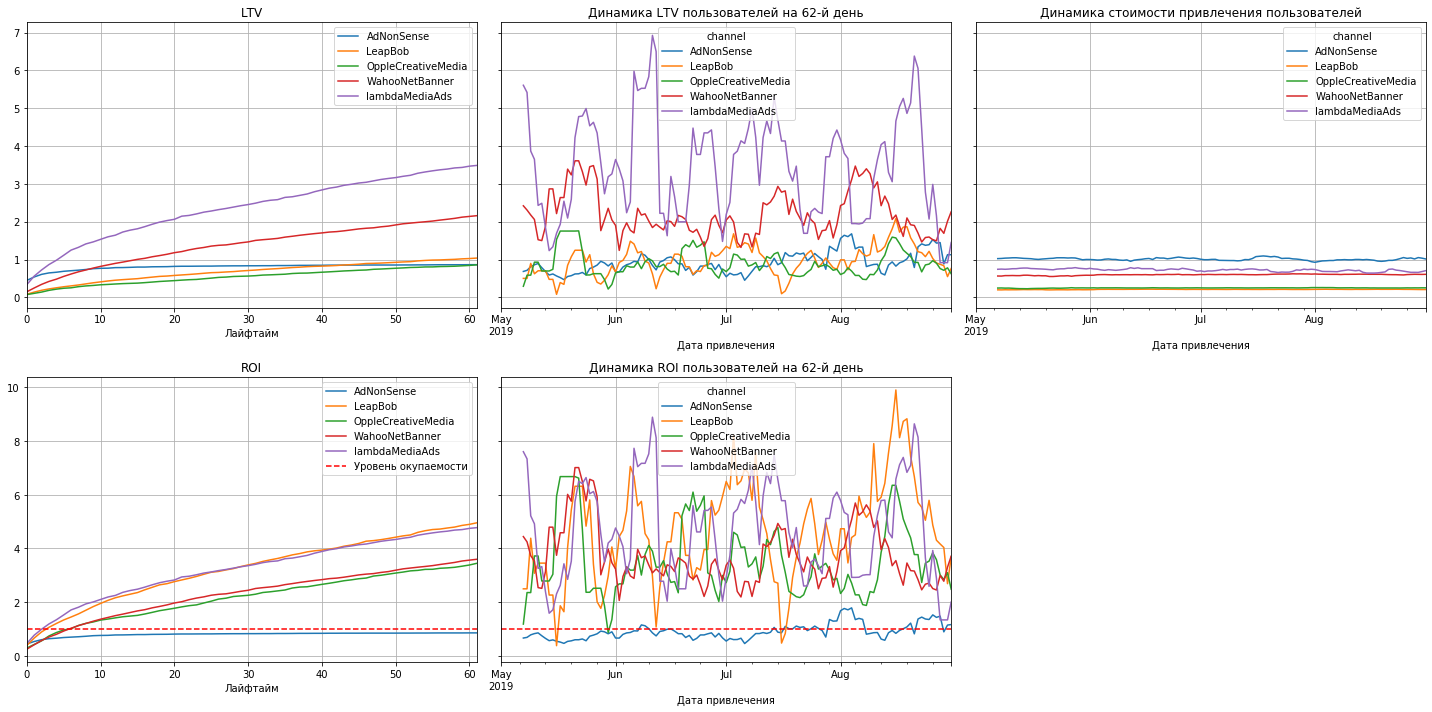

In [97]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ltv_raw, ltv_res, roi_res = get_ltv(profiles[profiles['channel_auditory'] != 'USA'], orders, max_date, 62, ['channel'])
ltv_hist_raw, ltv_hist_res, roi_hist_res = get_ltv(profiles[profiles['channel_auditory'] != 'USA'], orders, max_date, 62, ['dt', 'channel'])
plot_ltv_roi(ltv_res, ltv_hist_res, roi_res, roi_hist_res, 62)

#### Конверсия

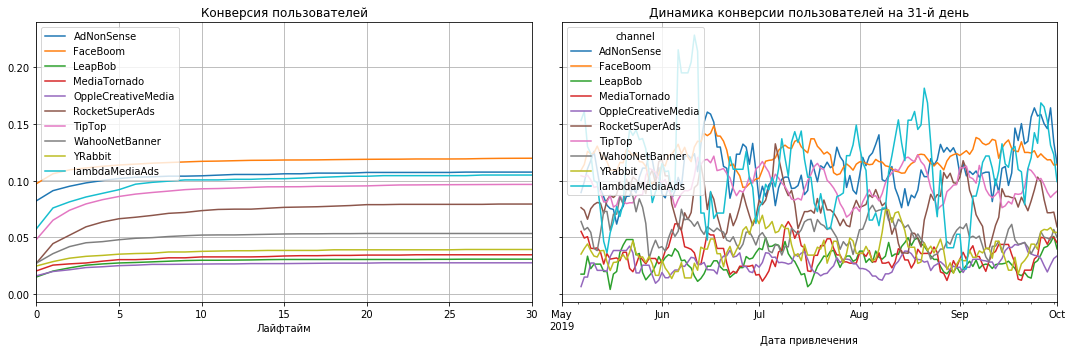

In [100]:
max_date = pd.to_datetime(orders['event_dt'].max()).date()
conv_raw, conv_res = get_conversion(profiles, orders, max_date, 31, ['channel'])
conv_hist_raw, conv_hist = get_conversion(profiles, orders, max_date, 31, ['dt','channel'])
plot_conversion(conv_res, conv_hist, 31)

FaceBoom и AdNonSense конвертируются лучше прочих.

#### Удержание

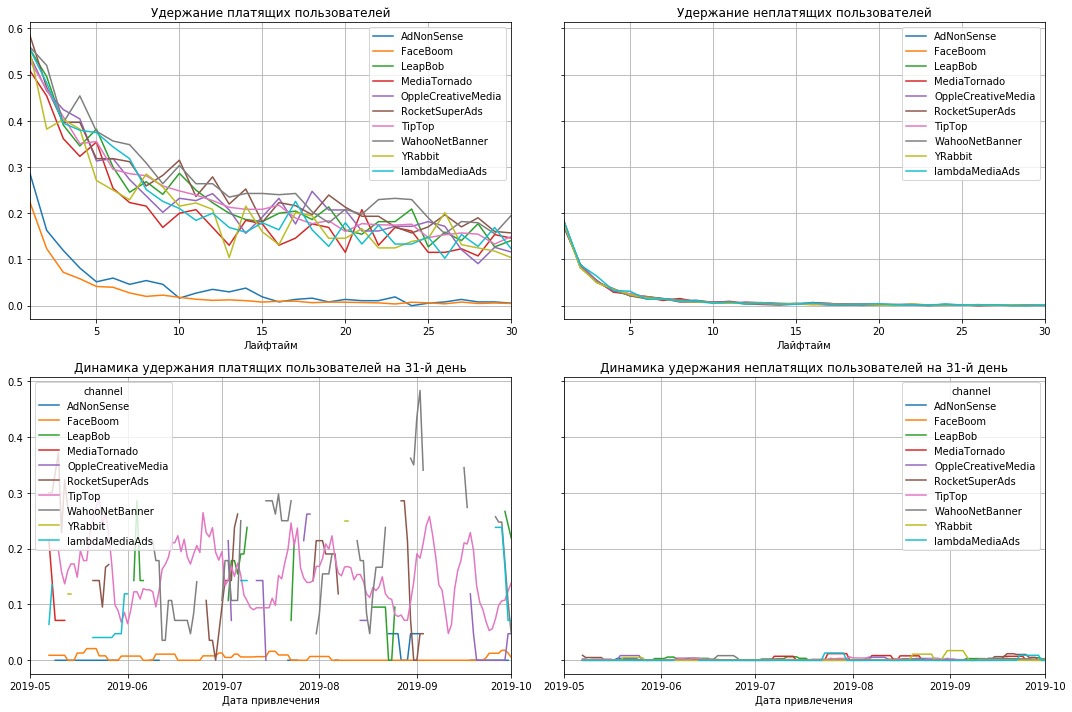

In [99]:
max_date = pd.to_datetime(visits['session_start'].max()).date()
ret_raw, ret_res = get_retention(profiles, visits, max_date, 31, ['channel'])
ret_hist_raw, ret_hist = get_retention(profiles, visits, max_date, 31, ['channel', 'dt'])
plot_retention(ret_res, ret_hist, 31)

Пользователи AdNonSense и FaceBoom имеют наихудшее удержание.

# Выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

Каналы AdNonSense и FaceBoom убыточны, пользователи с этих каналов по какой то причине не удерживаются. Увеличение вложений в маркетинг на каналах FaceBoom и TipTop в июне имели отклик, однако дальнейшие вложения в эти каналы отклика уже не имели, возможно эти каналы достигли своего предела. Маркетинг в целом заточен под apple и USA, хотя пользователи других стран и платформ показывают хороший roi и конверсию. Следует рекламироватся в других регионах и на разных платформах а не только под apple и США. 